In [1]:
%load_ext autoreload
%autoreload 2

#import sys
#sys.path.insert(1, '/home/lauraelina.uronen/silmarel/')

import numpy as np 

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel

import silmarel
from silmarel.simulation.data_sim import ModelSim
from silmarel.data.em_data import ImageData
from silmarel.data.gw_data import GWData
from silmarel.likelihood.lenstronomy_likeli import LenstronomyLikelihood

/home/lauraelina.uronen/.conda/envs/silmarel-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# lens characteristics
center_x, center_y = 0, 0
z_lens = 0.7
# source (EM) characteristics
source_x, source_y = 0.07, 0.03
z_source = 1.5

lens_model_list = ['EPL', 'SHEAR']
lens_light_model_list = ['SERSIC_ELLIPSE'] 
source_light_model_list = ['SERSIC_ELLIPSE']

kwargs_model = {'lens_model_list': lens_model_list,
                'lens_light_model_list': lens_light_model_list,
                'source_light_model_list': source_light_model_list}

kwargs_epl = {'theta_E': 1.0, 
                'center_x': center_x, 
                'center_y': center_y, 
                'e1': 0.1, 
                'e2': 0., 
                'gamma': 2}
kwargs_shear = {'gamma1': 0.1, 
                'gamma2': 0.2}
kwargs_lens = [kwargs_epl, kwargs_shear]

# lens light
kwargs_lens_light_mag = [{'amp': 50, 
                          'R_sersic': .2, 
                          'n_sersic': 4, 
                          'e1': 0.1, 
                          'e2': 0., 
                          'center_x': center_x, 
                          'center_y': center_y}]
# source light
kwargs_source_mag = [{'amp': 100, 
                      'R_sersic': 0.05, 
                      'n_sersic': 1, 
                      'e1': -0.3, 
                      'e2': -0.2, 
                      'center_x': source_x, 
                      'center_y': source_y}]

lensModel = LensModel(lens_model_list=lens_model_list, z_source=z_source, z_lens=z_lens)
lensLightModel = LightModel(light_model_list=lens_light_model_list)
sourceLightModel = LightModel(light_model_list=source_light_model_list)

In [ ]:
numPix = 60
deltaPix = 0.067 
shift = numPix * deltaPix / 2
ra_start, dec_start = center_x - shift, center_y - shift
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix

fwhm = 0.067 #HST/JWST: 0.067, TMT/ELT: 0.01 in IR

background_rms = None
exposure_time = 2200

kwargs_pixel = {'nx': numPix, 
                'ny': numPix, 
                'ra_at_xy_0': ra_start, 
                'dec_at_xy_0': dec_start, 
                'transform_pix2angle': transform_pix2angle}
kwargs_psf = {'psf_type': 'GAUSSIAN', 
              'fwhm': fwhm, 
              'pixel_size': deltaPix}
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
kwargs_data = {'image_data': None, 'background_rms': background_rms, 'exposure_time': exposure_time, 'ra_at_xy_0': ra_start, 'dec_at_xy_0': dec_start, 'transform_pix2angle': transform_pix2angle}
gw_kwargs = {'ra' : source_x, 'dec' : source_y}

models = [lensModel, sourceLightModel, lensLightModel]
kwargs_models = [kwargs_lens, kwargs_source_mag, kwargs_lens_light_mag]
kwargs_settings = [kwargs_data, kwargs_psf, kwargs_pixel, kwargs_numerics]

In [4]:
model = ModelSim(models, kwargs_models, kwargs_settings, gw_kwargs)

/home/lauraelina.uronen/.conda/envs/silmarel-dev/lib/python3.10/site-packages/lenstronomy/LensModel/Profiles/epl.py:297: RuntimeWarning: invalid value encountered in divide
  R_omega = Z * hyp2f1(1, t / 2, 2 - t / 2, -(1 - q) / (1 + q) * (Z / Z.conj()))


/local/lauraelina.uronen/ipykernel_621830/1163669524.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(model.image_data))


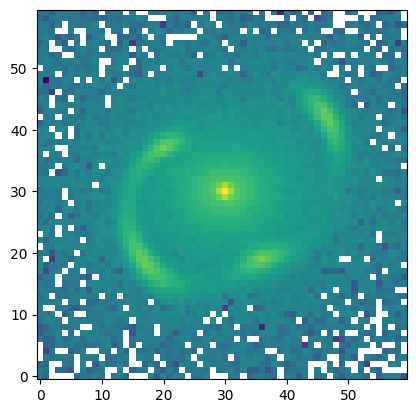

In [5]:
import matplotlib.pyplot as plt 

plt.imshow(np.log10(model.image_data))

In [6]:
gw_unc = {'delta_t' : 0.05, 'relative_magnification' : 0.2, 'luminosity_distance' : 500}

gwdata = GWData(n_images = 4, sim = model.gw_data, sim_sigma = gw_unc)
imagedata = ImageData(kwargs_data = model.settings.kwargs_data, 
                        kwargs_psf = model.settings.kwargs_psf,
                        kwargs_numerics = model.settings.kwargs_numerics)

In [7]:
##############################
# SET UP LENS RECONSTRUCTION #
##############################
# lens models
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})  # for this example, we fix the power-law index of the lens model to be isothermal
kwargs_lens_init.append({'theta_E': 1.0, 'e1': 0., 'e2': 0.,
                         'center_x': 0., 'center_y': 0., 
                         'gamma': 2.0})
kwargs_lens_sigma.append({'theta_E': .5, 'e1': 0.1, 'e2': 0.1,
                         'center_x': 0.1, 'center_y': 0.1, 
                         'gamma': 0.5})
kwargs_lower_lens.append({'theta_E': 0.5, 'e1': -0.5, 
                          'e2': -0.5, 'center_x': -0.1, 
                          'center_y': -0.1, 'gamma': 1.0})
kwargs_upper_lens.append({'theta_E': 1.5, 'e1': 0.5, 
                          'e2': 0.5, 'center_x': 0.1, 
                          'center_y': 0.1, 'gamma': 3.0})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0.1, 'gamma2': 0.2})
kwargs_lens_sigma.append({'gamma1': 0.05, 'gamma2': 0.05})
kwargs_lower_lens.append({'gamma1': -0.5, 'gamma2': -0.5})
kwargs_upper_lens.append({'gamma1': 0.5, 'gamma2': 0.5})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, 
               kwargs_lower_lens, kwargs_upper_lens]

fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append({'R_sersic': 0.05, 'n_sersic': 1, 
                           'e1': 0, 'e2': 0, 'center_x': 0., 
                           'center_y': 0.0, 'amp': 10})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.02, 
                            'e1': 0.5, 'e2': 0.5, 'center_x': 0.2, 
                            'center_y': 0.2, 'amp': 500})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 
                            'R_sersic': 0.01, 'n_sersic': .5, 
                            'center_x': -0.1, 'center_y': -0.1, 
                            'amp': 0.1})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 
                            'R_sersic': 0.5, 'n_sersic': 5., 
                            'center_x': 0.1, 'center_y': 0.1, 
                            'amp': 100})

source_params = [kwargs_source_init, kwargs_source_sigma, 
                 fixed_source, kwargs_lower_source, kwargs_upper_source]

fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.2, 'n_sersic': 4,
                               'e1': 0.0, 'e2': 0.0, 'center_x': 0., 
                               'center_y': 0, 'amp': 10})
kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.1,
                                'e1': 0.5, 'e2': 0.5, 'center_x': 0.1, 
                                'center_y': 0.1, 'amp': 5})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5,
                                'R_sersic': 0.01, 'n_sersic': .5, 
                                'center_x': -0.1, 'center_y': -0.1, 
                                'amp': 0.1})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5,
                                'R_sersic': 1, 'n_sersic': 5., 
                                'center_x': 0.1, 'center_y': 0.1, 
                                'amp': 100})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma,
                     fixed_lens_light, kwargs_lower_lens_light,
                     kwargs_upper_lens_light]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                }

In [ ]:
kwargs_params_gw = {'x' : {'min': -1, 'max': 1},
                    'y' : {'min': -1, 'max': 1},
                    'z_s': {'min': 1.0, 'max': 2.0}}

In [9]:
fastlikelihood = LenstronomyLikelihood(
    em_data = imagedata, 
    gw_data = gwdata, 
    em_prior = kwargs_params,
    gw_prior = kwargs_params_gw,
    models = kwargs_model, 
    z_l = 0.7, 
    z_s = None, 
    outdir = 'outdir_test'
)

In [10]:
fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 10,
                                'n_iterations': 1000}],
                       ['MCMC', {'n_burn': 100, 'n_run': 100,
                                 'n_walkers': 50, 'sigma_scale': .1}]]

fastlikelihood.run_lens_reconstruction(fitting_kwargs_list)

Computing the PSO ...


  0%|          | 0/1000 [00:00<?, ?it/s]

 66%|██████▌   | 661/1000 [00:15<00:07, 43.95it/s]


Converged after 661 iterations!
Best fit found:  -27234.057837186312 [0.9807107388715816, 1.9411049767163362, -0.007864179775119289, -0.00800909075279415, -0.0008574331965591771, -0.029479324769624917, 0.04183289737398881, 0.1926808085480376, 79.60532651562515, 0.06359546163546353, 0.9923008151200882, -0.013048488444494032, 0.09046087424930029, 0.05987610461211905, 0.0030852327592097487, 49.138393204266116, 0.20381465168998286, 4.012721245571485, 0.005516224192960175, -0.0444618383659359, 5.649871487022084e-05, -4.839579670836114e-05]
-15.223061954827452 reduced X^2 of best position
-27234.057837186312 log likelihood
3578 effective number of data points
[{'theta_E': 0.9807107388715816, 'gamma': 1.9411049767163362, 'e1': -0.007864179775119289, 'e2': -0.00800909075279415, 'center_x': -0.0008574331965591771, 'center_y': -0.029479324769624917}, {'gamma1': 0.04183289737398881, 'gamma2': 0.1926808085480376, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 79.60532651562515, 'R_sersic': 0.0635954

100%|██████████| 200/200 [00:22<00:00,  8.98it/s]

Computing the MCMC...
Number of walkers =  50
Burn-in iterations:  100
Sampling iterations (in current run): 200
22.374751329421997 time taken for MCMC sampling


-20.633874808668313 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  20.633874808668313


/home/lauraelina.uronen/.conda/envs/silmarel-dev/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:161: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),


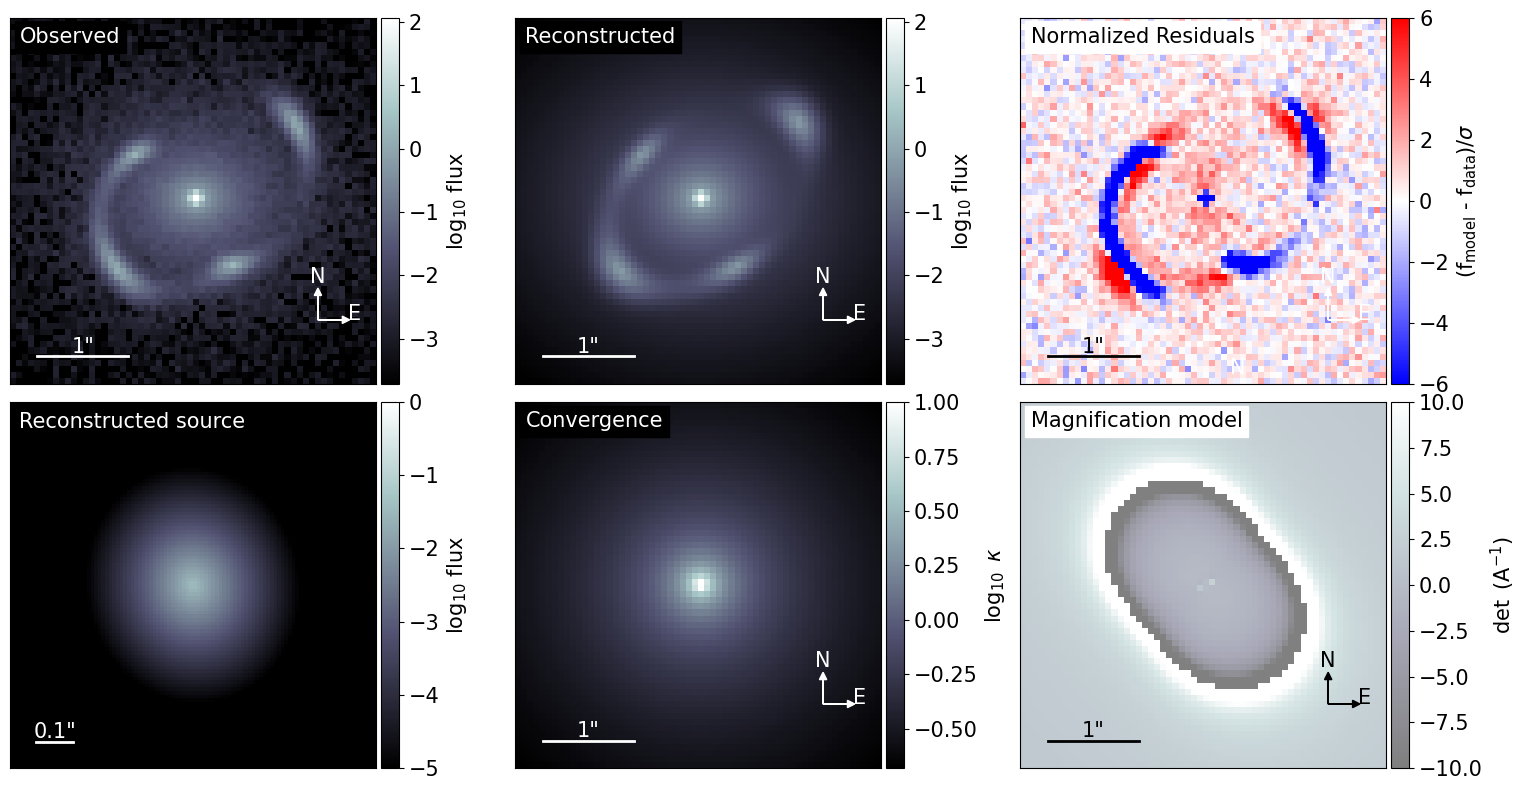

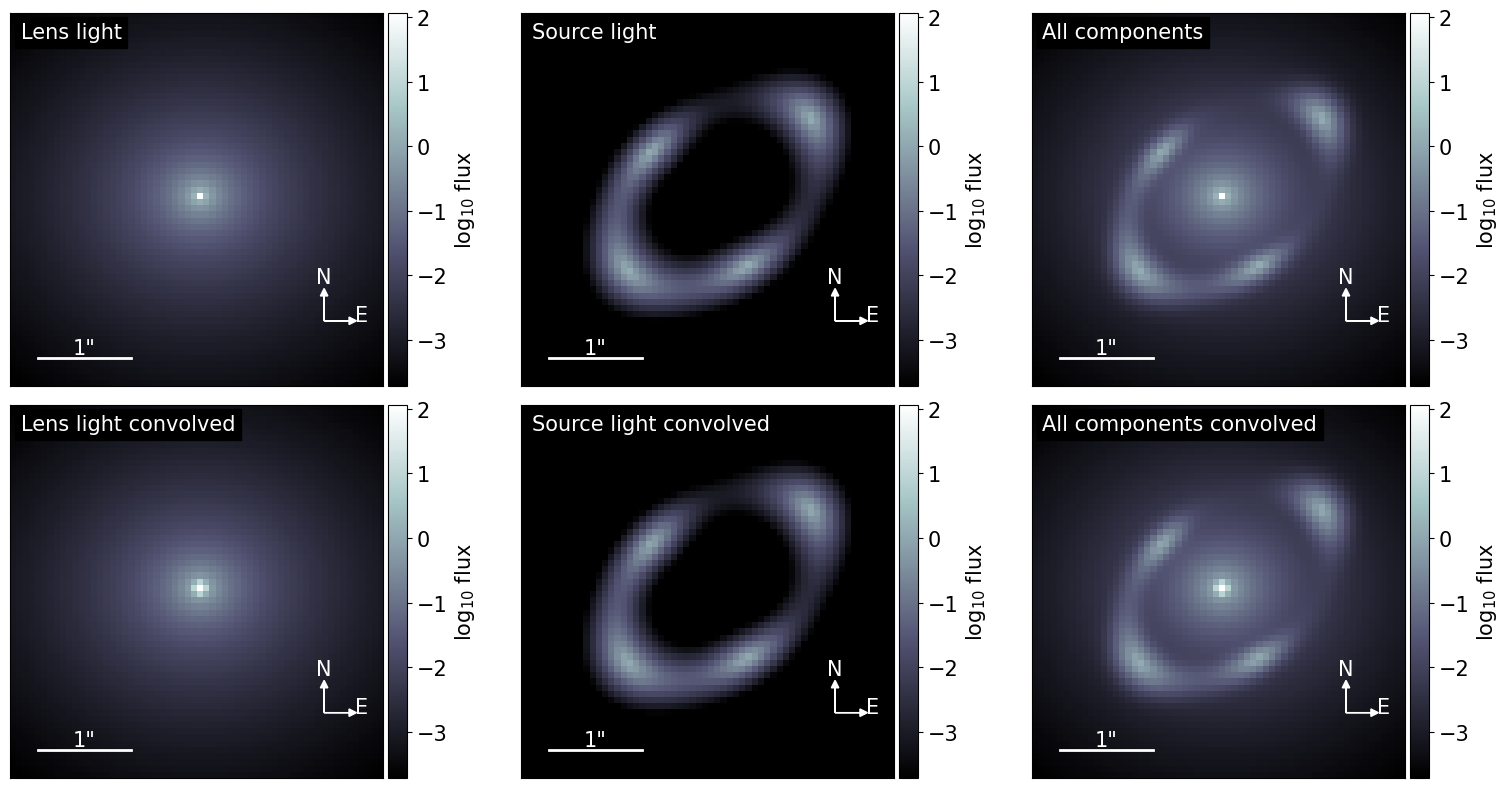

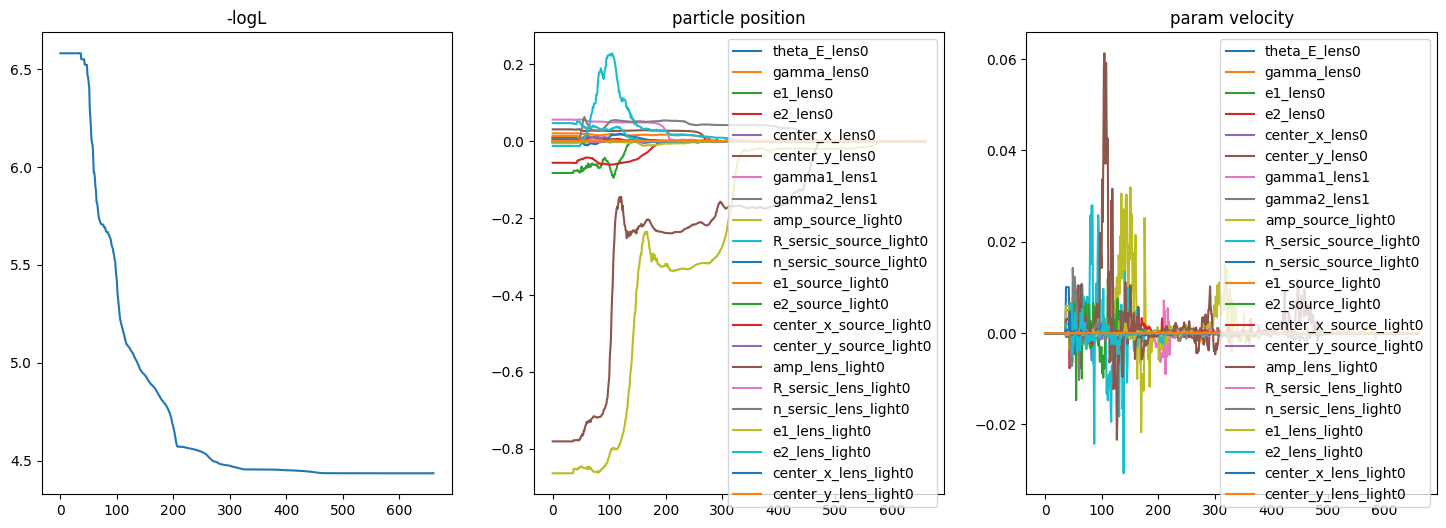

<Figure size 640x480 with 0 Axes>

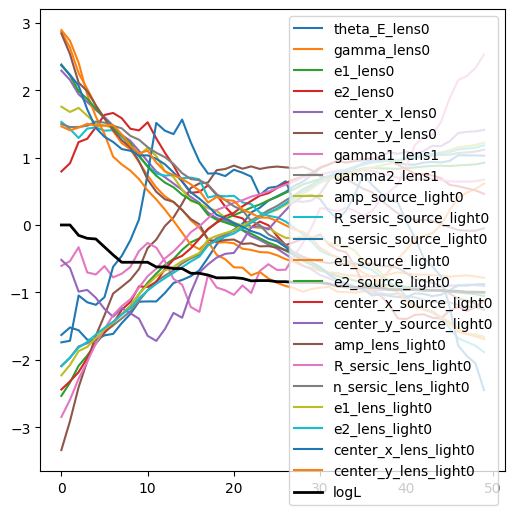

In [11]:
fastlikelihood.plot_reconstruction()

/home/lauraelina.uronen/silmarel/silmarel/silmarel/data/gw_data.py:81: RuntimeWarning: invalid value encountered in scalar multiply
  self.sigma.append(t * self.sim_sigma['delta_t'])
/home/lauraelina.uronen/silmarel/silmarel/silmarel/data/gw_data.py:72: RuntimeWarning: invalid value encountered in scalar multiply
  self.sigma.append(mag * self.sim_sigma['relative_magnification'])
  0%|          | 0/100 [00:00<?, ?it/s]/home/lauraelina.uronen/.conda/envs/silmarel-dev/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


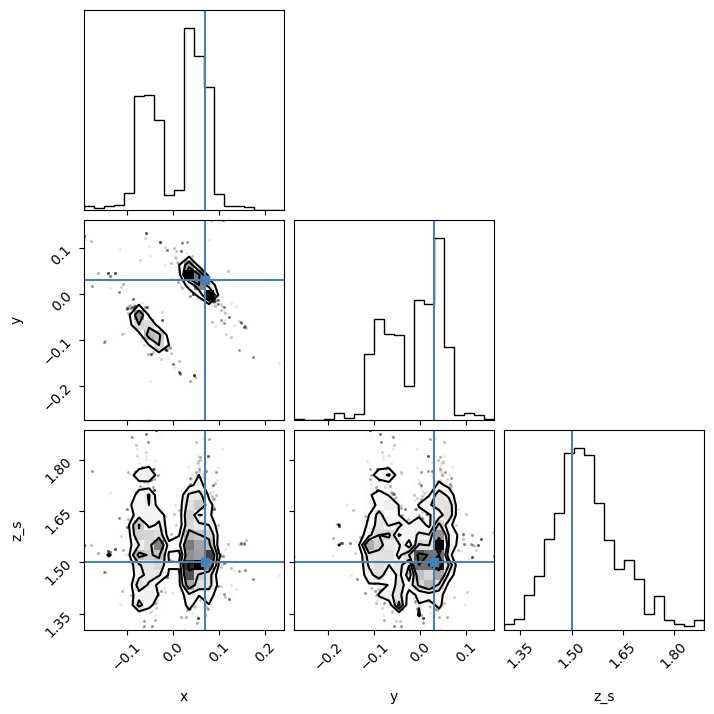

In [12]:
fastlikelihood.run_gw_localisation(n_iter=100)